In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, roc_auc_score,
                           confusion_matrix, ConfusionMatrixDisplay)
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking.client import MlflowClient
from pathlib import Path
import logging

# Configuração de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configuração do MLflow
def setup_mlflow():
    """Configura o ambiente MLflow com Model Registry"""
    Path("mlruns").mkdir(exist_ok=True)
    mlflow.set_tracking_uri("http://localhost:5050")
    mlflow.set_experiment("CreditCardFraud_ModelRegistry")

class FraudDetectionModel:
    def __init__(self):
        self.client = MlflowClient()
        
    def load_data(self, dataset_path):
        """Carrega e valida os dados"""
        try:
            df = pd.read_csv(dataset_path)
            logger.info(f"Dados carregados. Shape: {df.shape}")
            return df
        except Exception as e:
            logger.error(f"Erro ao carregar dados: {e}")
            raise

    def preprocess_data(self, df):
        """Pré-processamento completo"""
        df_processed = df.copy()
        
        # 1. Limpeza
        df_processed = df_processed.drop_duplicates()
        
        # 2. Normalização
        scaler = StandardScaler()
        df_processed[['Time', 'Amount']] = scaler.fit_transform(
            df_processed[['Time', 'Amount']]
        )
        
        # 3. Balanceamento
        X = df_processed.drop(columns=['Class'])
        y = df_processed['Class']
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        
        return X_res, y_res

    def train_model(self, X, y, model, model_name):
        """Treina e avalia um modelo"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred)
        }
        
        # Log de métricas adicionais
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.savefig(f"confusion_matrix_{model_name}.png")
        
        return model, metrics

    def register_model(self, model, model_name, X_train, metrics):
        """Registra o modelo no MLflow Model Registry"""
        with mlflow.start_run(run_name=f"{model_name}_Registration"):
            # 1. Log de parâmetros e métricas
            mlflow.log_params(model.get_params())
            mlflow.log_metrics(metrics)
            mlflow.log_artifact(f"confusion_matrix_{model_name}.png")
            
            # 2. Assinatura do modelo
            signature = infer_signature(X_train, model.predict(X_train))
            
            # 3. Registro no Model Registry
            model_uri = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path=model_name.lower(),
                signature=signature,
                registered_model_name=model_name
            ).model_uri
            
            # 4. Adiciona metadados
            model_version = self.client.search_model_versions(
                f"name='{model_name}'"
            )[0].version
            
            self.client.update_model_version(
                name=model_name,
                version=model_version,
                description=f"Modelo {model_name} para detecção de fraudes | AUC: {metrics['roc_auc']:.4f}"
            )
            
            logger.info(f"Modelo {model_name} registrado como versão {model_version}")
            return model_uri, model_version

    def promote_model(self, model_name, version, stage):
        """Promove uma versão para staging/production"""
        self.client.transition_model_version_stage(
            name=model_name,
            version=version,
            stage=stage
        )
        logger.info(f"Modelo {model_name} versão {version} promovido para {stage}")

    def deploy_model(self, model_name):
        """Gera o container para o modelo"""

        model_info = self.client.get_latest_versions(model_name, stages=["Staging"])[0]
        print(model_info.run_id)

        mlflow.models.build_docker(
            model_uri=f"runs:/{model_info.run_id}/{model_name.lower()}",
            name=model_name.lower(),
            enable_mlserver=True
        )

        logger.info(f"Docker {model_name} gerado com sucesso.")


def main():
    # 1. Configuração
    setup_mlflow()
    fraud_model = FraudDetectionModel()
    
    try:
        # 2. Carregar dados
        df = fraud_model.load_data("data/creditcard.csv")
        
        # 3. Pré-processamento
        X, y = fraud_model.preprocess_data(df)
        
        # 4. Definição dos modelos
        models = {
            "Fraud_LogisticRegression": LogisticRegression(
                solver='liblinear',
                max_iter=1000,
                random_state=42
            ),
            "Fraud_XGBoost": XGBClassifier(
                n_estimators=150,
                max_depth=4,
                learning_rate=0.05,
                random_state=42,
                eval_metric='logloss',
                use_label_encoder=False
            )
        }
        
        # 5. Treino e registro
        for model_name, model in models.items():
            # Treino
            trained_model, metrics = fraud_model.train_model(X, y, model, model_name)
            
            # Registro
            model_uri, version = fraud_model.register_model(
                trained_model,
                model_name,
                X,
                metrics
            )
            
            # Promoção automática do melhor modelo
            if metrics['f1'] > 0.9:  # Threshold personalizável
                fraud_model.promote_model(model_name, version, "Staging")
                model_name_deploy = model_name
                

        print(f"Modelo {model_name_deploy} registrado com sucesso.") 
        # 6. Implantação
        fraud_model.deploy_model(model_name_deploy)
        

                
    except Exception as e:
        logger.error(f"Erro no pipeline: {e}")
        raise


INFO:__main__:Dados carregados. Shape: (284807, 31)
Registered model 'Fraud_LogisticRegression' already exists. Creating a new version of this model...
2025/04/20 19:48:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Fraud_LogisticRegression, version 4
Created version '4' of model 'Fraud_LogisticRegression'.
INFO:__main__:Modelo Fraud_LogisticRegression registrado como versão 4
/var/folders/k_/z5zc1nfx4fv0xmghks2bdhv80000gq/T/ipykernel_63107/3068849548.py:125: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  self.client.transition_model_version_stage(
INFO:__main__:Modelo Fraud_LogisticRegression versão 4 promovido p

🏃 View run Fraud_LogisticRegression_Registration at: http://localhost:5050/#/experiments/223920342058916763/runs/da98195f97614fb68044d97a34d0c2a3
🧪 View experiment at: http://localhost:5050/#/experiments/223920342058916763


/Users/andre/Projects/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Registered model 'Fraud_XGBoost' already exists. Creating a new version of this model...
2025/04/20 19:48:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Fraud_XGBoost, version 4
Created version '4' of model 'Fraud_XGBoost'.
INFO:__main__:Modelo Fraud_XGBoost registrado como versão 4
/var/folders/k_/z5zc1nfx4fv0xmghks2bdhv80000gq/T/ipykernel_63107/3068849548.py:125: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.

🏃 View run Fraud_XGBoost_Registration at: http://localhost:5050/#/experiments/223920342058916763/runs/4a468d14ea0b4c22902a28838abbf011
🧪 View experiment at: http://localhost:5050/#/experiments/223920342058916763
Modelo Fraud_XGBoost registrado com sucesso.
4a468d14ea0b4c22902a28838abbf011


2025/04/20 19:48:56 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/04/20 19:48:56 INFO mlflow.pyfunc.backend: Building docker image with name fraud_xgboost
#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 2.51kB 0.0s done
#1 DONE 0.1s

#2 [internal] load metadata for docker.io/library/ubuntu:20.04
#2 DONE 1.1s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [ 1/17] FROM docker.io/library/ubuntu:20.04@sha256:8feb4d8ca5354def3d8fce243717141ce31e2c428701f6682bd2fafe15388214
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 246.53kB 0.0s done
#5 DONE 0.1s

#6 [ 9/17] RUN pip install mlflow==2.21.0
#6 CACHED

#7 [ 2/17] RUN apt-get -y update && DEBIAN_FRONTEND=noninteractive TZ=Etc/UTC apt-get install -y --no-install-recommends wget curl nginx ca-certificates bzip2 build-essential cmake git-cor

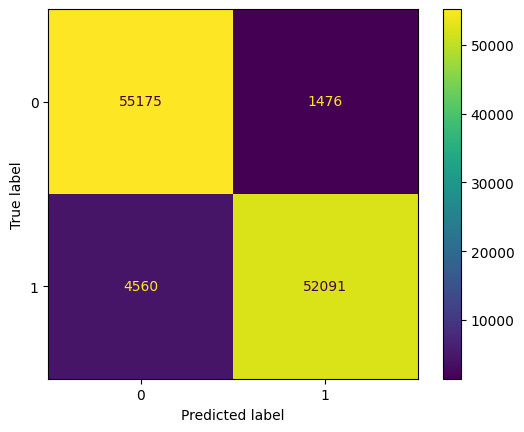

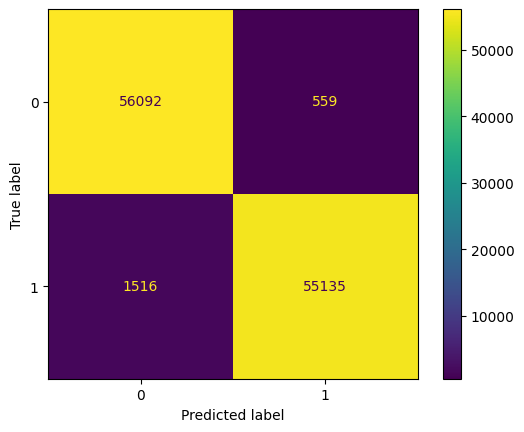

In [26]:
if __name__ == "__main__":
    # Antes de executar:
    # mlflow ui --backend-store-uri sqlite:///mlflow.db --host 127.0.0.1 --port 5000
    main()